# Confidence intervals and statistical tests

Hypothesis testing and confidence intervals are the most basic but also the most powerful concepts of classical statistics. 
In the following, we will show how these concepts are interlinked and how one should interpret results.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from pandas import Series
from pandas import DataFrame

from tqdm import tnrange
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. The number of heads in a finite sequence of coin flips

It is easy to verify that the probability to get exactly $k$ ones in $n$ independent identical trials $B_1,\ldots,B_n$ is

\begin{align*}
\Pr[B_1+\ldots+B_n=k]=\binom{n}{k}p^k(1-p)^{n-k}
\end{align*}

where $p$ is the probability to get one in a trial $B_i$. 
The corresponding distribution is known as a binomial distribution and is available as `scipy.stats.binom`:

* `rvs` is for sampling 
* `pmf` is for computing probabilities $\Pr[B_1+\ldots+B_n=k]$
* `cdf` is for computing probabilities $\Pr[B_1+\ldots+B_n\leq k]$
* `ppf` is for computing quantiles, i.e., for solving $\mathrm{argmax}_k\Pr[B_1+\ldots+B_n\leq k]\leq\alpha$
* `mean`, `var`, `median`, ... for standard statistical parameters 

In [2]:
from scipy.stats import binom

### Visualisation of basic aspects of a binomial distribution

In [3]:
n = 20
k = range(n)

# Tabulated binomial distribution with tails containing up to 2.5% of probability mass
pmf = (DataFrame({'k':list(k), 'pr': binom.pmf(k, n, p=0.5)})
       .assign(lower_tail = (k < binom.ppf(0.025, n, p=0.5)))
       .assign(upper_tail = (k > binom.ppf(0.975, n, p=0.5)))
       .assign(tail = lambda df: df['lower_tail'] | df['upper_tail']))

display(pmf)

,k,pr,lower_tail,upper_tail,tail
0,0,9.536743e-07,True,False,True
1,1,1.907349e-05,True,False,True
2,2,1.811981e-04,True,False,True
3,3,1.087189e-03,True,False,True
4,4,4.620552e-03,True,False,True
5,5,1.478577e-02,True,False,True
6,6,3.696442e-02,False,False,False
7,7,7.392883e-02,False,False,False
8,8,1.201344e-01,False,False,False
9,9,1.601791e-01,False,False,False


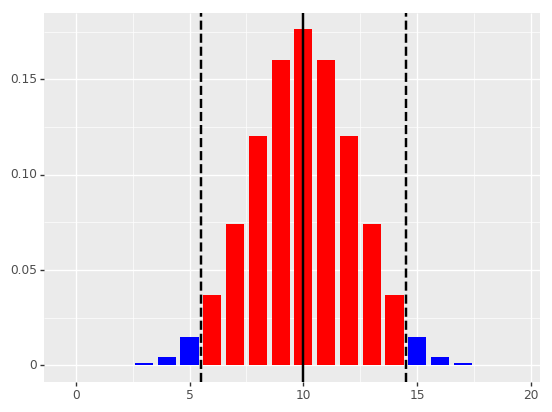

<ggplot: (7542997992)>

In [4]:
p = ggplot(pmf)
p = p + geom_col(aes(x = 'k', y = 'pr', fill='tail'), width = 0.8)
p = p + geom_vline(xintercept = binom.ppf(0.025, n=20, p=0.5) - 0.5, linetype ='--', size = 1)
p = p + geom_vline(xintercept = binom.ppf(0.975, n=20, p=0.5) + 0.5, linetype ='--', size = 1)
p = p + geom_vline(xintercept = binom.ppf(0.500, n=20, p=0.5) + 0.0, linetype ='-',  size = 1)
p = p + scale_x_continuous(name = '') + scale_y_continuous(name = '')
p = p + scale_fill_manual(guide = False, values = ['red', 'blue'])
p.save('binomial_distribution.pdf', path='results', height=6, width=12, verbose=False)
display(p)

## II. Confidence intervals for the probability

The most naive way to find confidence intervals for a binomial distribution is the following:
* Define a statistical test for all possible values of the parameter $p\in[0,1]$ by computing $2.5\%$ and $97.5\%$ quantiles.
* Tabulate for each observed integer value $k$ what tests are passed and extend the corresponding parameter set into an interval. 

### Tabulate quantiles for all parameter values

In [5]:
n = 20
tdf = DataFrame(index = range(11)).assign(p = lambda df: df.index.values/(len(df)-1))
tdf

,p
0,0.0
1,0.1
2,0.2
3,0.3
4,0.4
5,0.5
6,0.6
7,0.7
8,0.8
9,0.9


In [7]:
tdf['q1'] = tdf['p'].apply(lambda p: binom.ppf(0.025, n, p))
tdf['q2'] = tdf['p'].apply(lambda p: binom.ppf(0.975, n, p))
tdf

,p,q1,q2
0,0.0,19.0,0.0
1,0.1,0.0,5.0
2,0.2,1.0,8.0
3,0.3,2.0,10.0
4,0.4,4.0,12.0
5,0.5,6.0,14.0
6,0.6,8.0,16.0
7,0.7,10.0,18.0
8,0.8,12.0,19.0
9,0.9,15.0,20.0


In [8]:
# Let's correct the obvious scipy error
tdf.loc[0, 'q1'] = 0
display(tdf)    

,p,q1,q2
0,0.0,0.0,0.0
1,0.1,0.0,5.0
2,0.2,1.0,8.0
3,0.3,2.0,10.0
4,0.4,4.0,12.0
5,0.5,6.0,14.0
6,0.6,8.0,16.0
7,0.7,10.0,18.0
8,0.8,12.0,19.0
9,0.9,15.0,20.0


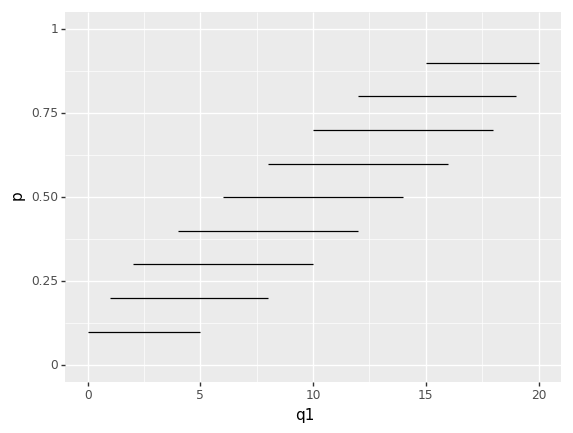

<ggplot: (7542992367)>

In [9]:
p = ggplot(tdf)
p + geom_segment(aes(x = 'q1', xend = 'q2', y = 'p', yend = 'p')) 

### Tabulate accepted hypotheses for each observation

In [12]:
df =[None] * 21
for k in range(21):
    df[k] = DataFrame({'observed_k': k, 'accepted_p': tdf.loc[(tdf['q1'] <= k) & (k<= tdf['q2']), 'p']})
df = pd.concat(df, ignore_index=True)
head(df, 10)

,observed_k,accepted_p
0,0,0.0
1,0,0.1
2,1,0.1
3,1,0.2
4,2,0.1
5,2,0.2
6,2,0.3
7,3,0.1
8,3,0.2
9,3,0.3


In [13]:
# As we use a finite grid, we must extend the interval to bordering grid points
sdf = (df.groupby(['observed_k']).aggregate([min, max])
       .pipe(lambda df: reset_column_index(df, 0))
       .reset_index()
       .assign(maxp = lambda df: df['max'] + 0.1)
       .assign(minp = lambda df: df['min'] - 0.1))

mdisplay([head(df), head(sdf)], ['Accepted parameters', 'Extended intervals'])

Accepted parameters Extended intervals 
 
 
 observed_k 
 accepted_p 
 
 
 
 
 0 
 0.0 
 
 
 0 
 0.1 
 
 
 1 
 0.1 
 
 
 1 
 0.2 
 
 
 2 
 0.1 
 
 
 
 
 
 observed_k 
 min 
 max 
 maxp 
 minp 
 
 
 
 
 0 
 0.0 
 0.1 
 0.2 
 -0.1 
 
 
 1 
 0.1 
 0.2 
 0.3 
 0.0 
 
 
 2 
 0.1 
 0.3 
 0.4 
 0.0 
 
 
 3 
 0.1 
 0.3 
 0.4 
 0.0 
 
 
 4 
 0.1 
 0.4 
 0.5 
 0.0

### Visualisation of the search procedure

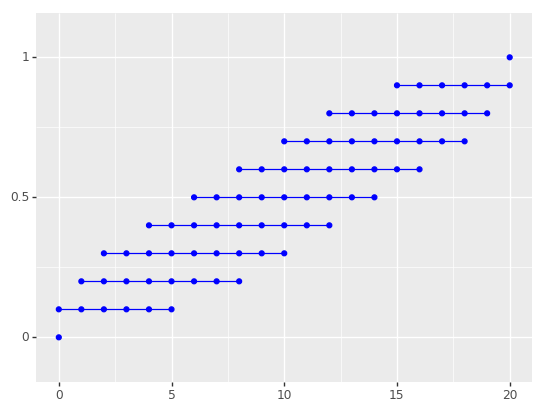

<ggplot: (-9223372029311552459)>

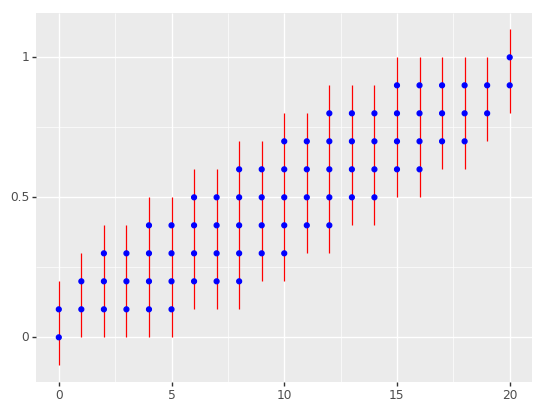

<ggplot: (7543223318)>

In [14]:
p = ggplot(tdf)
p = p + geom_segment(aes(x = 'q1', xend = 'q2', y = 'p', yend = 'p'), color = 'blue') 
p = p + geom_point(aes(x = 'observed_k', y = 'accepted_p'), color = 'blue', data = df)
p = p + scale_x_continuous(name = '')
p = p + scale_y_continuous(name = '', limits=(-0.1, 1.1), breaks = [0, 0.5, 1.0])
p.save('bin_conf_intervals_i.pdf', path='results', height=6, width=6, verbose=False)
display(p)


p = ggplot(df)
p = p + geom_segment(aes(x = 'observed_k', xend = 'observed_k', y='minp', yend ='maxp'), color = 'red', data=sdf)
p = p + geom_point(aes(x = 'observed_k', y = 'accepted_p'), color = 'blue')
p = p + scale_x_continuous(name = '')
p = p + scale_y_continuous(name = '', limits=(-0.1, 1.1), breaks = [0, 0.5, 1.0])
p.save('bin_conf_intervals_ii.pdf', path='results', height=6, width=6, verbose=False)
display(p)

## III. What does the confidence level mean?

The confidence level is a subtle concept. Most importantly, the confidence level **is not** a probability that the true parameter value is inside the confidence interval. Confidence level $\alpha$ shows uncertaintly related to the average case behaviour.

If one could repeat the data collection infinite amount of times and compute the confidence interval for each of them then in $\alpha$-fraction of runs the true parameter value is inside the interval.
This does not say anything about the particular run and a confidence interval we are interested in.

To get an actionable outcome, we must use ultra-fequentist resolution and state that the true value is inside the interval as events with probability $1-\alpha$ do not happen. 
The latter is slighty silly for $90\%$ and $95\%$ confidence intervals but this is how engineers work.


### Example case

In the following we conduct simulations to illustrate these concepts:
* The parameter to be estimated will be the  probability $\Pr[B_i=1]$.
* The observed value will be the number of heads in the coinflipping experiment.

We use the method [statsmodels.stats.proportion.proportion_confint](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html) from `statsmodels` to compute confidence intervals in the experiment.
This function implements six different methods for computing confidence intervals.
We use `binom_test` as it coincides with the method we described earlier.

In [15]:
from statsmodels.stats.proportion import proportion_confint

In [16]:
r = 40

# Confidence intervals at significance level 5%
obs1 = (DataFrame({'k': binom.rvs(n=20, p=0.5, size=r)})
        .assign(q1 = lambda df: df['k'].apply(
                            lambda k: proportion_confint(k, nobs=n, alpha = 0.05, method = 'binom_test')[0]))
        .assign(q2 = lambda df: df['k'].apply(
                            lambda k: proportion_confint(k, nobs=n, alpha = 0.05, method = 'binom_test')[1]))
        .assign(fails = lambda df: (0.5 < df['q1']) | (df['q2'] < 0.5))
        .assign(alpha = r'$\alpha =95\%$')
        .assign(y = lambda df: (df.index.values + 1)/len(df.index))
        )

head(obs1)

,k,q1,q2,fails,alpha,y
0,7,0.166821,0.576413,False,$\alpha =95\%$,0.025
1,8,0.208933,0.627797,False,$\alpha =95\%$,0.050
2,5,0.104081,0.474569,True,$\alpha =95\%$,0.075
3,8,0.208933,0.627797,False,$\alpha =95\%$,0.100
4,12,0.372203,0.791067,False,$\alpha =95\%$,0.125


In [17]:
# Confidence intervals at significance level 20%
obs2 = (obs1[['k']]
        .assign(q1 = lambda df: df['k'].apply(
                                lambda k: proportion_confint(k, nobs=n, alpha = 0.20, method = 'binom_test')[0]))
        .assign(q2 = lambda df: df['k'].apply(
                                lambda k: proportion_confint(k, nobs=n, alpha = 0.20, method = 'binom_test')[1]))
        .assign(fails = lambda df: (0.5 < df['q1']) | (df['q2'] < 0.5))
        .assign(alpha = r'$\alpha =80\%$')
        .assign(y = lambda df: (df.index.values + 1)/len(df.index))
)

mdisplay([head(obs1), head(obs2)], ['Large intervals', 'Small intervals'])

Large intervals Small intervals 
 
 
 k 
 q1 
 q2 
 fails 
 alpha 
 y 
 
 
 
 
 7 
 0.166821 
 0.576413 
 False 
 $\alpha =95\%$ 
 0.025 
 
 
 8 
 0.208933 
 0.627797 
 False 
 $\alpha =95\%$ 
 0.050 
 
 
 5 
 0.104081 
 0.474569 
 True 
 $\alpha =95\%$ 
 0.075 
 
 
 8 
 0.208933 
 0.627797 
 False 
 $\alpha =95\%$ 
 0.100 
 
 
 12 
 0.372203 
 0.791067 
 False 
 $\alpha =95\%$ 
 0.125 
 
 
 
 
 
 k 
 q1 
 q2 
 fails 
 alpha 
 y 
 
 
 
 
 7 
 0.231075 
 0.500000 
 False 
 $\alpha =80\%$ 
 0.025 
 
 
 8 
 0.261447 
 0.548953 
 False 
 $\alpha =80\%$ 
 0.050 
 
 
 5 
 0.146317 
 0.402008 
 True 
 $\alpha =80\%$ 
 0.075 
 
 
 8 
 0.261447 
 0.548953 
 False 
 $\alpha =80\%$ 
 0.100 
 
 
 12 
 0.451047 
 0.738553 
 False 
 $\alpha =80\%$ 
 0.125

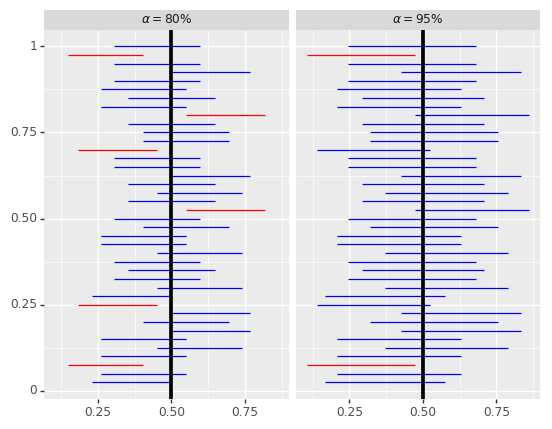

<ggplot: (7543216290)>

In [18]:
p = ggplot(pd.concat([obs1, obs2]))
p = p + geom_segment(aes(x = 'q1', xend = 'q2', y = 'y', yend='y', color = 'fails'))
p = p + facet_wrap(['alpha'])
p = p + geom_vline(xintercept = 0.5, size = 1.5)
p = p + scale_x_continuous(name = '') + scale_y_continuous(name = '')
p = p + scale_color_manual(guide = False, values = ['blue', 'red'])
p.save('confidence_intervals_example.pdf', path='results', height=6, width=12, verbose=False)
display(p)

# Homework  

## 1.1 Comparison of different confidence interval methods (<font color='red'>1p</font>)

The function `proportion_confint` implements six different methods for computing confidence intervals. 
Most of them are approximations. Compare how well these methods work. For that, execute the following simulation:
* Sample observations from a binomial distribution.
* Compute different confidence intervals for each observation.
* Estimate the fraction of correct guesses for each method and tabulate the results using `geom_col`.
* Show the expected baseline value on each plot or facet.

Try different values of $n\in\{20, 100\}$ and different confidence levels $\alpha\in\{90\%, 99\%\}$. 
Interpret results. Are there any significant differences between different methods? 
You can also visualise the locations of the confidence intervals using `geom_jitter`.

In [38]:
p = 0.4
n = 20
r = 1000

obs = DataFrame({'k': binom.rvs(n=n, p=p, size=r)})

In [39]:
obs['q0']=proportion_confint(obs.loc[:,'k'], nobs=n, alpha = 0.05, method = 'normal')[0]
obs['q1']=proportion_confint(obs.loc[:,'k'], nobs=n, alpha = 0.05, method = 'normal')[1]

In [40]:
obs['fail'] = (obs['q0']>p) |(obs['q1']<p)
obs['success'] = ~obs['fail']

In [41]:
obs['success'].mean()

0.939

In [ ]:
.assign(q1 = lambda df: df['k'].apply(
                                lambda k: proportion_confint(k, nobs=n, alpha = 0.20, method = 'binom_test')[0]))

In [ ]:
        .assign(q2 = lambda df: df['k'].apply(
                                lambda k: proportion_confint(k, nobs=n, alpha = 0.20, method = 'binom_test')[1]))

## 1.2 Confidence intervals and engineering tradeoffs* (<font color='red'>2p</font>)

In practice, one often needs to find the right trade-off between the length of the interval and the expected fraction of failures where the true parameter value is outside the interval. Consider the following two-stage measurement scheme. You can first do low-precision measurements to determine the approximate value of $y_0$ and later use high precision measurement device to get the final measurement value. Each low precision measurement costs $0.05$ € and the high precision measurement costs proportionally to the length of the initial interval estimate. A high-precision scan through a unit length interval costs 1 €. 

Describe at least two possible measurement strategies and use simulation to estimate their efficiency, i.e. the average amount of money needed to get a successful high-precision measurement.
During the simulation, assume that the true paramater value $y_0=0.5$ and low quality measurements come from a normal distribution `numpy.random.normal(loc=y_0, scale=0.2)`.

As you sample from the normal distribution, you need to find confidence intervals for estimating the mean value of normally distributed samples without knowing the variance. The corresponding method is implemented as [`statsmodels.stats.weightstats.zconfint`](https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.zconfint.html#statsmodels.stats.weightstats.zconfint).

## 1.3 Confidence intervals and multiple hypothesis testing (<font color='red'>1p</font>)

Confidence intervals are also impacted by the multiple hypothesis testing problem. Namely, the fraction of possible datasets where two or more confidence intervals hold simultaneously is significantly smaller than the fraction of datasets where one confidence interval holds. 

Assume that all intervals have the same confidence level $\alpha$ if we consider them separately. 
Let $F_i$ denote the event that the $i$th confidence interval is incorrect on the data sample.
If we estimate independent parameters, e.g. room temperature and length of a person, the probability that at least one confidence interval fails can be computed as follows:

\begin{align*}
\Pr[F_1=0\wedge \ldots\wedge F_m=0] = \Pr[F_1=0]\cdots \Pr[F_m=0]=(1-\alpha)^m\lesssim 1-m\alpha\enspace. 
\end{align*}

If these intervals are dependent, e.g. we estimate height and weight at the same time or recompute the paremeter based on an extended set of observations, then we can use only union bound:

\begin{align*}
\Pr[F_1=0\wedge\ldots\wedge F_m=0] &= 1- \Pr[F_1=1\vee\ldots\vee F_m=0]\\
  &\leq 1- \Pr[F_1=0]-\ldots-\Pr[F_m=0]=1-m\alpha\enspace. 
\end{align*}

These two bounds provide optimistic and pessimistic estimates on the confidence levels in standard settings, as it is much harder to reliably estimate the effect of correlations to approximation failures.


Study the difference between these estimates. Let the target confidence level be $95\%$. Compute what should be the confidence level $\alpha$ for an individual interval if we consider $m=1,2,4, \ldots, 1024$ intervals based on the optimistic and pessimistic estimates. Draw a corresponding lineplot.

Verify whether these estimates hold in practice by using samples from a fair coin and compute the corresponding confidence interval for the proportion:
* For each run, sample 1024 throws of an unbiased coin.
* Estimate $p$ from the first 256, 512, 1024 samples.
* You get three dependent confidence intervals.
* Estimate the fraction of runs for which $0.5$ is inside of all the intervals.
* Compare the result with the optimistic and pessimistic estimates.

Interpret results. How easy is it to build meaningful confidence intervals for many parameters if they must hold simultaneously?

In [43]:
0.95**3
1-0.05*3

0.85

In [9]:
%config IPCompleter.greedy=True